In [60]:
!python --version

Python 3.11.4


In [1]:
# Initalize Python libraries

import numpy as np
import pandas as pd
import requests
import shutil
import time as time
from os.path import join,expanduser
user_home_dir = expanduser('~')

# xarray is used to read and plot the downloaded NetCDF files
import xarray as xr
import sys

import matplotlib.pyplot as plt

# for concurrent simulatenous downloads
from concurrent.futures import ThreadPoolExecutor
from getpass import getpass
from http.cookiejar import CookieJar
from io import StringIO

from itertools import repeat
from pathlib import Path
from platform import system
from netrc import netrc
from os.path import basename, isfile, isdir
# progress bar
from tqdm import tqdm
# library to download files
from urllib import request

# Predict the path of the netrc file depending on os/platform type.
_netrc = join(user_home_dir, "_netrc" if system()=="Windows" else ".netrc")

# load the ecco_v4_py package
# here is is assumed to be installed in /home/user/ECCOv4-py
# change as needed for your setup
sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

In [2]:
# Helper subroutine to log into NASA EarthData

# not pretty but it works
def setup_earthdata_login_auth(url: str='urs.earthdata.nasa.gov'):
    # look for the netrc file and use the login/password
    try:
        username, _, password = netrc(file=_netrc).authenticators(url)

    # if the file is not found, prompt the user for the login/password
    except (FileNotFoundError, TypeError):
        print('Please provide Earthdata Login credentials for access.')
        username, password = input('Username: '), getpass('Password: ')

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, url, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

In [3]:
# Helper subroutines to make the API calls to search CMR and parse response

def set_params(params: dict):
    params.update({'scroll': "true", 'page_size': 2000})
    return {par: val for par, val in params.items() if val is not None}

def get_results(params: dict, headers: dict=None):
    response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.csv",
                            params=set_params(params),
                            headers=headers)
    return response, response.headers


def get_granules(params: dict):
    response, headers = get_results(params=params)
    scroll = headers['CMR-Scroll-Id']
    hits = int(headers['CMR-Hits'])
    if hits==0:
        raise Exception("No granules matched your input parameters.")
    df = pd.read_csv(StringIO(response.text))
    while hits > df.index.size:
        response, _ = get_results(params=params, headers={'CMR-Scroll-Id': scroll})
        data = pd.read_csv(StringIO(response.text))
        df = pd.concat([df, data])
    return df

In [4]:
# Helper subroutine to gracefully download single files and avoids re-downloading if file already exists.

# To force redownload of the file, pass **True** to the boolean argument *force* (default **False**)
def download_file(url: str, output_dir: str, force: bool=False):
    """
    url (str): the HTTPS url from which the file will download
    output_dir (str): the local path into which the file will download
    force (bool): download even if the file exists locally already
    """
    if not isdir(output_dir):
        raise Exception(f"Output directory doesnt exist! ({output_dir})")

    target_file = join(output_dir, basename(url))

    # if the file has already been downloaded, skip
    if isfile(target_file) and force is False:
        print(f'\n{basename(url)} already exists, and force=False, not re-downloading')
        return 0

    with requests.get(url) as r:
        if not r.status_code // 100 == 2:
            raise Exception(r.text)
            return 0
        else:
            with open(target_file, 'wb') as f:
                total_size_in_bytes= int(r.headers.get('content-length', 0))
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)

                return total_size_in_bytes

In [5]:
# Helper subroutine to download all urls in the list dls

def download_files_concurrently(dls, download_dir, force=False):
    start_time = time.time()

    # use 3 threads for concurrent downloads
    with ThreadPoolExecutor(max_workers=max_workers) as executor:

        # tqdm makes a cool progress bar
        results = list(tqdm(executor.map(download_file, dls,
                                         repeat(download_dir),
                                         repeat(force)), total=len(dls),
                            desc='DL Progress', ascii=True, ncols=75,file=sys.stdout))

        # add up the total downloaded file sizes
        total_download_size_in_bytes = np.sum(np.array(results))
        # calculate total time spent in the download
        total_time = time.time() - start_time

        print('\n=====================================')
        print(f'total downloaded: {np.round(total_download_size_in_bytes/1e6,2)} Mb')
        print(f'avg download speed: {np.round(total_download_size_in_bytes/1e6/total_time,2)} Mb/s')

In [6]:
# Download granules of an ECCO dataset falling within a specific date range
# Define dataset parameters

# ECCO dataset ShortName

# ... other datasets used in the tutorials
#ShortName = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
#ShortName = "ECCO_L4_OBP_LLC0090GRID_MONTHLY_V4R4"
#ShortName = "ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4"

ShortName = "ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4"

# desired date range
StartDate = "2000-01-01"
EndDate   = "2000-01-07"

In [7]:
# Download granules of an ECCO dataset falling within a specific date range
# Define download directory

# define root directory for downloaded NetCDF files
download_root_dir = Path(user_home_dir + '/Downloads/ECCO_V4r4_PODAAC')

# define the directory where the downloaded files will be saved
download_dir = download_root_dir / ShortName

# create the download directory
download_dir.mkdir(exist_ok = True, parents=True)

print(f'created download directory {download_dir}')

created download directory /Users/lilianapereira/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4


In [10]:
# Download granules of an ECCO dataset falling within a specific date range
# Log into Earthdata using your username and password

# actually log in with this command:
setup_earthdata_login_auth()

In [11]:
# Download granules of an ECCO dataset falling within a specific date range
# Search NASA’s “Common Metadata Repository” for the ECCO dataset

# create a Python dictionary with our search criteria:  `ShortName` and `temporal`
input_search_params = {'ShortName': ShortName,
                       'temporal': ",".join([StartDate, EndDate])}

print(input_search_params)

{'ShortName': 'ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4', 'temporal': '2000-01-01,2000-01-07'}


In [12]:
# Download granules of an ECCO dataset falling within a specific date range
# Query CMR for the desired ECCO Dataset

# grans means 'granules', PO.DAAC's term for individual files in a dataset
grans = get_granules(input_search_params)

# what did we find? --- 8 granules!
grans.info()

num_grans = len( grans['Granule UR'] )
print (f'\nTotal number of matching granules: {num_grans}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Granule UR           8 non-null      object 
 1   Producer Granule ID  0 non-null      float64
 2   Start Time           8 non-null      object 
 3   End Time             8 non-null      object 
 4   Online Access URLs   8 non-null      object 
 5   Browse URLs          0 non-null      float64
 6   Cloud Cover          0 non-null      float64
 7   Day/Night            8 non-null      object 
 8   Size                 8 non-null      float64
dtypes: float64(4), object(5)
memory usage: 708.0+ bytes

Total number of matching granules: 8


In [13]:
# Download granules of an ECCO dataset falling within a specific date range
# Download the granules

# convert the rows of the 'Online Access URLS' column to a Python list
dls = grans['Online Access URLs'].tolist()

# the url of the first file is
print(dls[0])

https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4/SEA_SURFACE_HEIGHT_day_mean_1999-12-31_ECCO_V4r4_native_llc0090.nc


In [72]:
max_workers = 12

In [73]:
# Ex 1) Force redownload if the file exists
force=True
download_files_concurrently(dls, download_dir, force)

DL Progress: 100%|###########################| 8/8 [00:11<00:00,  1.50s/it]

total downloaded: 47.42 Mb
avg download speed: 3.94 Mb/s


In [74]:
# Ex 2) Do not force redownload if the file exists
force=False
download_files_concurrently(dls, download_dir, force)


SEA_SURFACE_HEIGHT_day_mean_1999-12-31_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-02_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-01_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-04_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-06_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-07_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-03_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-05_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading
DL Progress: 100%|######################

In [14]:
# Check downloads

ecco_netcdf_files = list(download_dir.glob('*nc'))

print(f'number of downloaded files {len(ecco_netcdf_files)}')

number of downloaded files 15


In [15]:
# Plotting llc90 grid output on a global lon-lat map

xds = xr.open_mfdataset(ecco_netcdf_files, parallel=True, data_vars='minimal',\
                                  coords='minimal', compat='override')

print(xds)

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 15, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 1999-12-31T12:00:00 ... 2000-01-14T12:00:00
    ...         ...
    YC         (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 das

In [77]:
# select variable to plot from dataset
var_to_plot = 'SSH'
dataarray_plot = eval('xds.' + var_to_plot)

# compute the time mean over the downloaded files
time_mean = dataarray_plot.mean('time').compute()

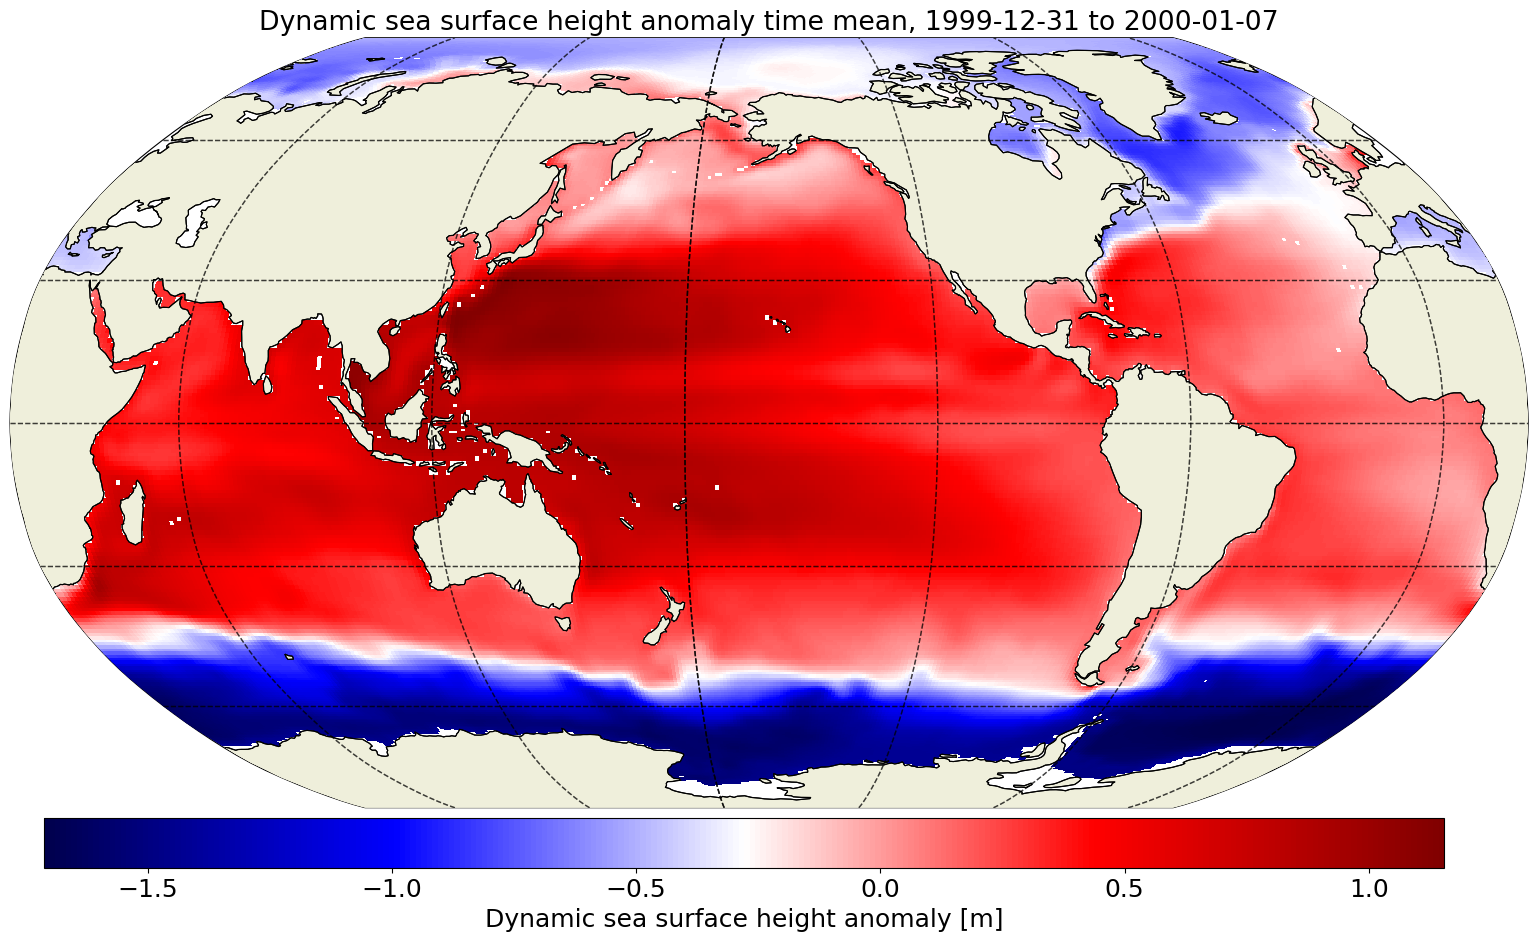

In [78]:
# use ecco_v4_py function to plot native grid data on lat-lon map
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=[20,10])
time_values = dataarray_plot.time.data
title_str = dataarray_plot.long_name + ' time mean, ' + str(time_values[0])[:10] + ' to ' + str(time_values[-1])[:10]
# scalar quantities generally have coordinates XC and YC for longitude and latitude respectively
# vectors (e.g. velocities, fluxes) have different coordinates; see Coordinates tutorial for more detail
plot_obj = ecco.plot_proj_to_latlon_grid(dataarray_plot.XC, dataarray_plot.YC, time_mean, show_colorbar=False, user_lon_0=200, cmap='seismic')
plt.title(title_str)
# create horizontal colorbar with label
cax = plt.axes([0.15,0.05,0.7,0.05])
cbar = plt.colorbar(plot_obj[2],cax=cax,orientation='horizontal')
cbar.set_label(dataarray_plot.long_name + ' [' + dataarray_plot.units + ']',fontsize=18)
cax.tick_params(labelsize=18)

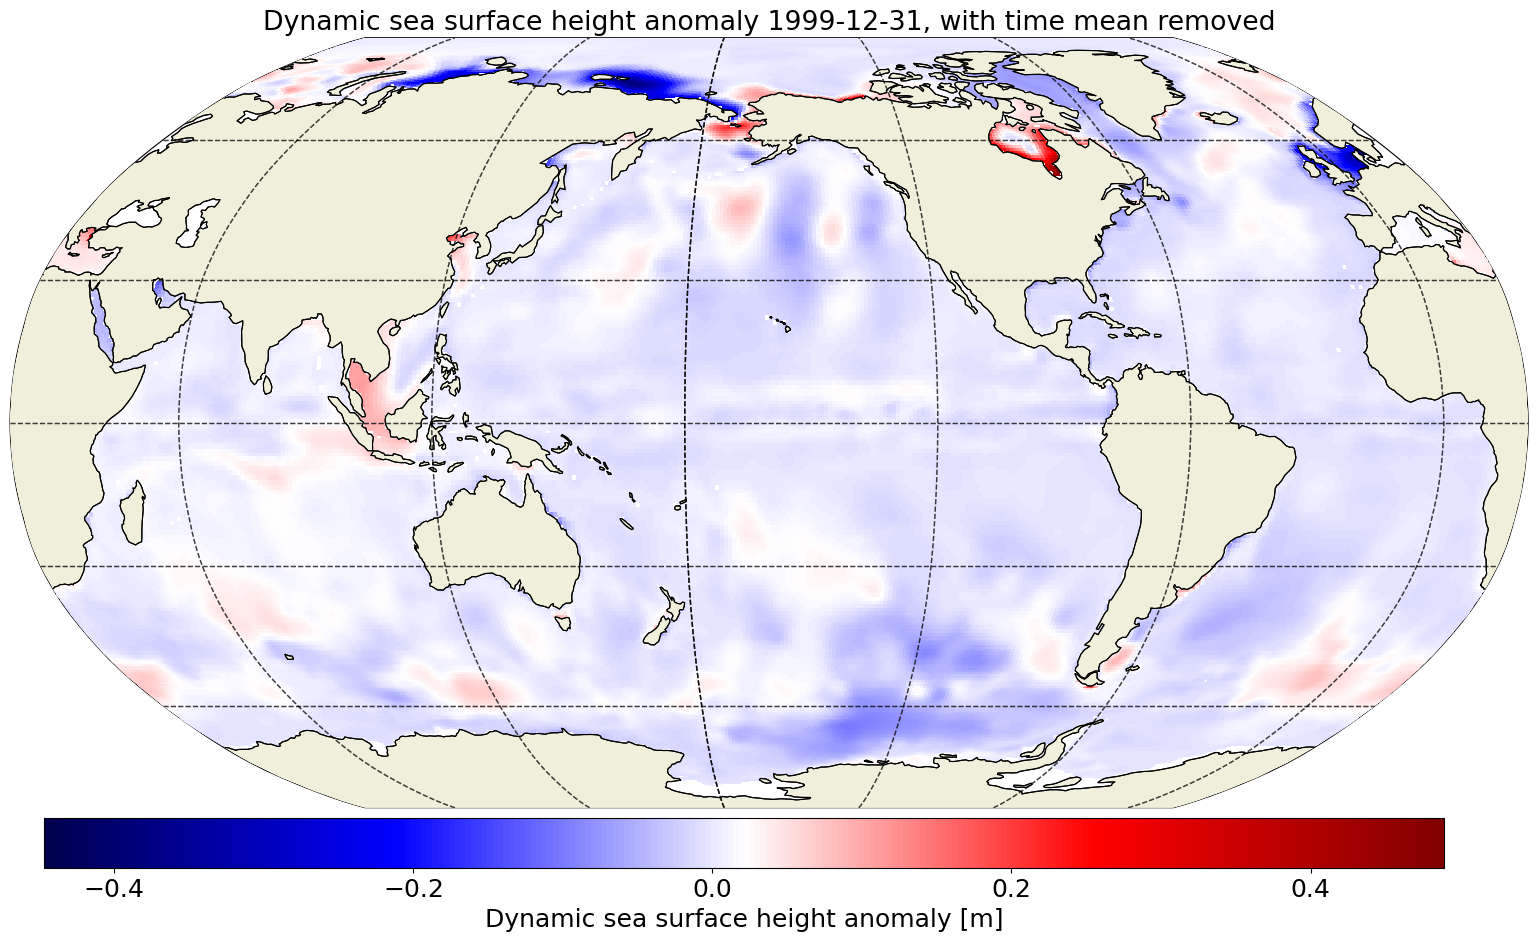

In [79]:
# Plot the anomaly of the first record (time_ind = 0) relative to the time mean
time_ind = 0
fig = plt.figure(figsize=[20,10])
title_str = dataarray_plot.long_name + ' ' + str(time_values[time_ind])[:10] + ', with time mean removed'
plot_obj = ecco.plot_proj_to_latlon_grid(dataarray_plot.XC, dataarray_plot.YC, dataarray_plot.isel(time=time_ind) - time_mean, show_colorbar=False, user_lon_0=200, cmap='seismic')
plt.title(title_str)
cax = plt.axes([0.15,0.05,0.7,0.05])
cbar = plt.colorbar(plot_obj[2],cax=cax,orientation='horizontal')
cbar.set_label(dataarray_plot.long_name + ' [' + dataarray_plot.units + ']',fontsize=18)
cax.tick_params(labelsize=18)

In [17]:
# ECCO_download module

from ecco_download import *

ecco_podaac_download(ShortName="ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4",\
                    StartDate="2000-01-09",EndDate="2000-01-14",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /Users/lilianapereira/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4
{'ShortName': 'ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4', 'temporal': '2000-01-09,2000-01-14'}

Total number of matching granules: 7

SEA_SURFACE_HEIGHT_day_mean_2000-01-08_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-09_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-10_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-12_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-13_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-14_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-11_EC